In [1]:
# parameters, export
kernel = "pack:1"
J = 5
seed = 4283955834
sample_idx = 13


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tinygp import GaussianProcess

from prism.pack import PACK
from utils.jax import vk

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_log_compiles", False)
# jax.config.update("jax_platform_name", "cpu") # GPU = 20x speedup


from dynesty import NestedSampler
from scipy.special import ndtri

from surrogate import source
from utils import time_this


In [3]:
lf_sample = source.get_lf_samples()[sample_idx]


def warp_time(t_ms, period_ms):
    return t_ms / period_ms


def dewarp_time(tau, period_ms):
    return tau * period_ms


lf_sample["tau"] = warp_time(lf_sample["t"], lf_sample["p"]["T0"])


[Memory]1.2s, 0.0min    : Loading get_lf_samples...


In [ ]:
d = int(kernel[-1])

NORMALIZED = False


def ptform(u):
    z = ndtri(u)
    return 10.0**z


def build_theta(x):
    return {
        "sigma_noise": x[0],
        "sigma_a": x[1],
        "sigma_b": x[2],
        "sigma_c": x[3],
    }


def build_kernel(theta):
    pack = PACK(
        d=d,
        normalized=NORMALIZED,
        J=J,
        sigma_b=theta["sigma_b"],
        sigma_c=theta["sigma_c"],
    )

    return theta["sigma_a"] ** 2 * pack


def build_gp(theta):
    pack = build_kernel(theta)
    gp = GaussianProcess(
        kernel=pack, X=lf_sample["tau"], diag=theta["sigma_noise"] ** 2
    )
    return gp


u = np.random.uniform(size=100)
x = ptform(u)
theta = build_theta(x)
pack = build_kernel(theta)


In [5]:
@jax.jit
def loglikelihood(x):
    theta = build_theta(x)
    gp = build_gp(theta)
    return gp.log_probability(lf_sample["u"])


loglikelihood(x)


Array(-240.46899566, dtype=float64)

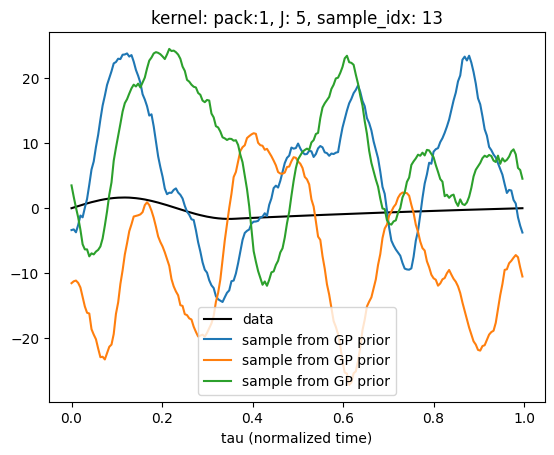

In [ ]:
# smoke test
rng = np.random.default_rng(seed)

x = ptform(rng.uniform(size=100))
theta = build_theta(x)
ndim = sum(v.size for v in theta.values())

s = build_gp(theta).sample(vk(), shape=(3,))

plt.title(f"kernel: {kernel}, J: {J}, sample_idx: {sample_idx}")
plt.plot(lf_sample["tau"], lf_sample["u"], c="black", label="data")
plt.plot(lf_sample["tau"], s.T, label="sample from GP prior")
plt.xlabel("tau (normalized time)")
plt.legend()


In [7]:
# initialize our nested sampler
nlive = 256

sampler = NestedSampler(
    loglikelihood, ptform, ndim, nlive=nlive, rstate=rng, sample="rwalk"
)

with time_this() as elapsed:
    sampler.run_nested(maxcall=1_000_000, print_progress=False)


3717it [00:48, 76.21it/s, +256 | bound: 73 | nc: 1 | ncall: 76556 | eff(%):  5.207 | loglstar:   -inf < 682.607 <    inf | logz: 669.514 +/-  0.217 | dlogz:  0.001 >  0.265]

Walltime: 48.775 s


In [8]:
res = sampler.results

res.summary()


Summary
nlive: 256
niter: 3717
ncall: 76300
eff(%):  5.207
logz: 669.514 +/-  0.313


{'sigma_noise_log10': np.float64(-2.662243231921124), 'sigma_a_log10': np.float64(0.3678328715089114), 'sigma_b_log10': np.float64(0.930187585223778), 'sigma_c_log10': np.float64(-0.6534630037526985)}
{'sigma_noise_log10': np.float64(0.0511477561960844), 'sigma_a_log10': np.float64(0.581408443282558), 'sigma_b_log10': np.float64(0.5862306988513089), 'sigma_c_log10': np.float64(0.5685728083949202)}
{'sigma_noise': np.float64(0.002067776905191302), 'sigma_a': np.float64(3.3527895776513263), 'sigma_b': np.float64(6.191460876406764), 'sigma_c': np.float64(0.14687020143567947)}
{'sigma_noise': np.float64(0.002553976492980045), 'sigma_a': np.float64(3.937962379650063), 'sigma_b': np.float64(4.050975246387374), 'sigma_c': np.float64(0.1136469257558105)}
{'sigma_noise': np.float64(0.002258217459142481), 'sigma_a': np.float64(7.565961627263356), 'sigma_b': np.float64(4.440692672611521), 'sigma_c': np.float64(0.07556009739118995)}
{'sigma_noise': np.float64(0.002553972960164137), 'sigma_a': np.f

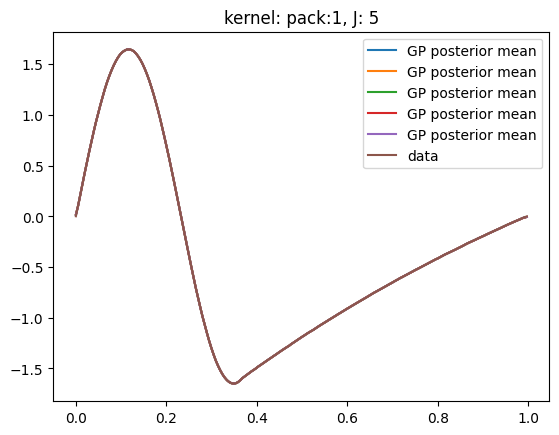

In [9]:
xs = res.samples_equal(rng)[:100]

means = {}
stds = {}

for x in xs:
    theta = build_theta(x)
    for k, v in theta.items():
        if "sigma" in k:
            v = np.log10(v)
            k = f"{k}_log10"
        means[k] = means.get(k, 0.0) + v
        stds[k] = stds.get(k, 0.0) + v * v

N = float(len(xs))

means = {k: v / N for k, v in means.items()}
stds = {k: np.sqrt(stds[k] / N - means[k] * means[k]) for k in means}

print(means)
print(stds)

for x in xs[:5]:
    theta = build_theta(x)

    print(theta)

    gp = build_gp(theta)
    mu, var = gp.predict(lf_sample["u"], lf_sample["tau"], return_var=True)
    std = jnp.sqrt(var) + theta["sigma_noise"]

    plt.fill_between(
        lf_sample["tau"],
        mu - 1.96 * std,
        mu + 1.96 * std,
        alpha=0.2,
    )
    plt.plot(lf_sample["tau"], mu, label="GP posterior mean")

plt.plot(lf_sample["tau"], lf_sample["u"], label="data")

plt.title(f"kernel: {kernel}, J: {J}")
plt.legend()


Quantiles:
sigma_noise [(0.05, 0.0018326146557212978), (0.5, 0.0022186984888002076), (0.95, 0.002594050691268153)]
Quantiles:
sigma_a [(0.05, 0.256172152399595), (0.5, 2.0819458697957933), (0.95, 18.850811039054623)]
Quantiles:
sigma_b [(0.05, 1.0811886037245009), (0.5, 9.730937252327696), (0.95, 79.78246958496047)]
Quantiles:
sigma_c [(0.05, 0.026772480465447404), (0.5, 0.24881187734521615), (0.95, 1.8368068632092867)]


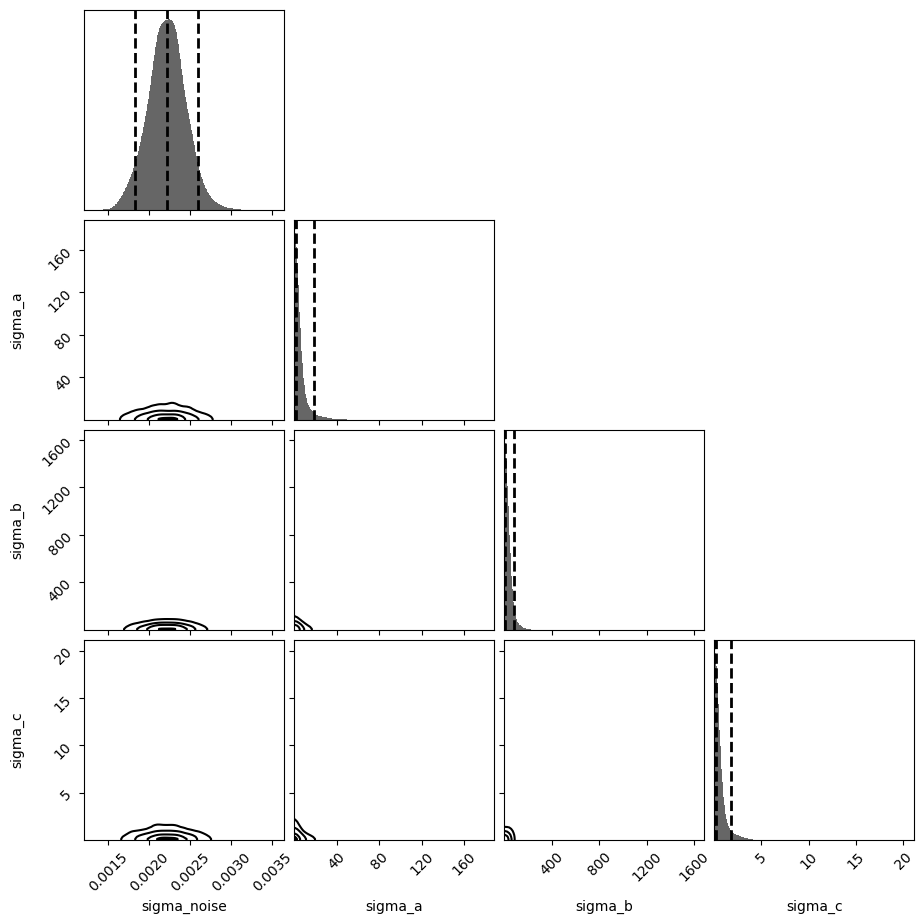

In [10]:
from dynesty import plotting as dyplot

labels = [str(k) for k in theta.keys()]

try:
    fig, ax = dyplot.cornerplot(
        res,
        labels=labels,
        verbose=True,
        quantiles=[0.05, 0.5, 0.95],
    )
except Exception as e:
    print(f"Could not make corner plot: {e}")


In [11]:
# export
mean = means
std = stds

logz = res.logz[-1]
logzerr = res.logzerr[-1]

log_prob_u = lf_sample["log_prob_u"]

ndim = res.samples.shape[1]
information = res.information[-1]

niter = res.niter
ncall = res.ncall.sum()
walltime = elapsed.walltime
